In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

# Rossmann

## Data preparation / Feature engineering

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz). Then you shold untar them in the dirctory to which `PATH` is pointing below.

For completeness, the implementation used to put them together is included below.

In [3]:
PATH=Config().data_path()/Path('rossmann/')
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
tables = [pd.read_csv(PATH/f'{fname}.csv', low_memory=False) for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [4]:
train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [5]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [6]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Join weather/state names.

In [7]:
weather.head(2),state_names.head(2)

(                 file        Date  Max_TemperatureC  Mean_TemperatureC  \
 0  NordrheinWestfalen  2013-01-01                 8                  4   
 1  NordrheinWestfalen  2013-01-02                 7                  4   
 
    Min_TemperatureC  Dew_PointC  MeanDew_PointC  Min_DewpointC  Max_Humidity  \
 0                 2           7               5              1            94   
 1                 1           5               3              2            93   
 
    Mean_Humidity  ...  Max_VisibilityKm  Mean_VisibilityKm  Min_VisibilitykM  \
 0             87  ...              31.0               12.0               4.0   
 1             85  ...              31.0               14.0              10.0   
 
    Max_Wind_SpeedKm_h  Mean_Wind_SpeedKm_h  Max_Gust_SpeedKm_h  \
 0                  39                   26                58.0   
 1                  24                   16                 NaN   
 
    Precipitationmm  CloudCover  Events  WindDirDegrees  
 0             5.08   

In [8]:
weather = join_df(weather, state_names, "file", "StateName")

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [9]:
googletrend.head(2)

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95


In [10]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [11]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [12]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [13]:
googletrend.head(2)

,file,week,trend,Date,State,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN,2012,12,48,2,6,337,False,False,False,False,False,False,1354406400
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN,2012,12,49,9,6,344,False,False,False,False,False,False,1355011200


The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [14]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why not just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [15]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [16]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [17]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [18]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [19]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [20]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [21]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [22]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

We'll replace some erroneous / outlying data.

In [23]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [24]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates. You may need to install the `isoweek` package first.

In [25]:
# If needed, uncomment:
! pip3 install isoweek

In [26]:
from isoweek import Week
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [27]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [28]:
joined.to_pickle(PATH/'joined')
joined_test.to_pickle(PATH/'joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [29]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [30]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [31]:
#df = train[columns]
df = train[columns].append(test[columns])

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [32]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We'll do this for two more fields.

In [33]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [34]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [35]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [36]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [37]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [38]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [39]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [40]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [41]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [42]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [43]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [44]:
df.drop(columns,1,inplace=True)

In [45]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [46]:
df.to_pickle(PATH/'df')

In [47]:
df["Date"] = pd.to_datetime(df.Date)

In [48]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [49]:
joined = pd.read_pickle(PATH/'joined')
joined_test = pd.read_pickle(PATH/f'joined_test')

In [50]:
joined = join_df(joined, df, ['Store', 'Date'])

In [51]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [52]:
joined = joined[joined.Sales!=0]

We'll back this up as well.

In [53]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [54]:
joined.to_pickle(PATH/'train_clean')
joined_test.to_pickle(PATH/'test_clean')

# Predicting customers first

In [55]:
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [56]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [57]:
train_df.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week',
       'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'file_DE', 'week_DE', 'trend_DE', 'Date_DE',
       'State_DE', 'Month_DE', 'Day_DE', 'Dayofweek_DE', 'Dayofyear_DE',
       'Is_month_end_DE', 'Is_month_start_DE', 'Is_quarter_end_DE',
       'Is_quarter_start_DE', 'Is_year_end_DE', 'Is_year_start_DE',
       'Elapsed_DE', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
      

In [58]:
n = len(train_df); n

844338

### Experimenting with a sample

In [59]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [60]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
365,367,5,NaN,2640.0,61,7514
596,598,5,"Jan,Apr,Jul,Oct",550.0,50,6675
3283,1060,3,"Feb,May,Aug,Nov",3430.0,67,8159
4469,18,1,"Jan,Apr,Jul,Oct",13840.0,79,10055
5320,870,1,NaN,780.0,66,8199


In [61]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
427859,364,2,"Mar,Jun,Sept,Dec",13620.0,70,4066
428127,634,2,NaN,18610.0,89,4540
428646,41,1,"Jan,Apr,Jul,Oct",1180.0,89,6422
429308,707,1,NaN,2900.0,79,7920
429827,83,6,NaN,2710.0,77,2855


In [62]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [63]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
427859,NaN,2,"Mar,Jun,Sept,Dec",13620.0,70,4066
428127,634,2,NaN,18610.0,89,4540
428646,NaN,1,"Jan,Apr,Jul,Oct",1180.0,89,6422
429308,NaN,1,NaN,2900.0,79,7920
429827,83,6,NaN,2710.0,77,2855


In [64]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [65]:
small_train_df['PromoInterval'].cat.codes[:5]

365    -1
596     1
3283    0
4469    1
5320   -1
dtype: int8

In [66]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [67]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
8443,622,4,NaN,2305.0,67,3970,True
56144,879,3,"Feb,May,Aug,Nov",2305.0,60,5155,True


### Preparing full data set

In [68]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [69]:
len(train_df),len(test_df)

(844338, 41088)

In [70]:
procs=[FillMissing, Categorify, Normalize]

In [71]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [72]:
dep_var = 'Customers'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [73]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [74]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [75]:
valid_idx = range(cut)

In [76]:
df[dep_var].head()

0     555
1     625
2     821
3    1498
4     559
Name: Customers, dtype: int64

In [77]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

## Model

In [78]:
max_log_y = np.log(np.max(train_df['Customers'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [79]:
learn = tabular_learner(data, layers=[1000,500], wd=0.2, ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [80]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


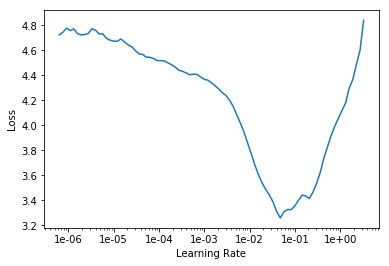

In [81]:
learn.recorder.plot()

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.019900,0.014524,0.124775,01:56
1,0.015095,0.012824,0.103011,02:00
2,0.013115,0.011325,0.108526,01:58
3,0.009005,0.007515,0.086019,01:58
4,0.007715,0.006929,0.080353,01:59


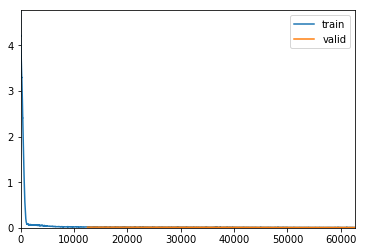

In [82]:
learn.fit_one_cycle(5, 1e-3,callbacks=[ShowGraph(learn)])

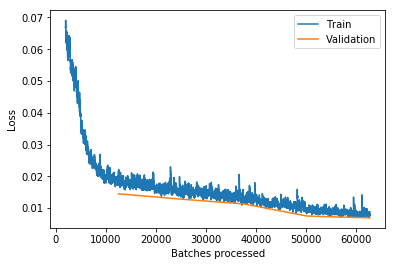

In [83]:
learn.recorder.plot_losses(skip_start=2000)

In [84]:
learn.save('Customers-1')

In [85]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.009015,0.009406,0.091157,01:58
1,0.010432,0.009504,0.093003,01:57
2,0.009621,0.007681,0.086444,01:58
3,0.008095,0.006762,0.079643,01:57
4,0.006777,0.006728,0.079000,01:57


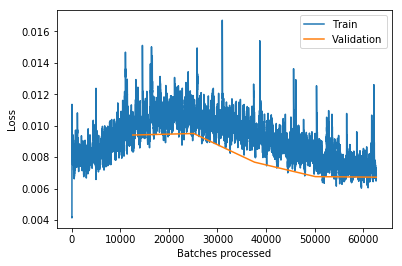

In [86]:
learn.recorder.plot_losses()

(10th place in the competition was 0.108)

In [87]:
learn.save('Customers-2')

In [ ]:
test_preds=learn.get_preds(DatasetType.Test)
test_df[dep_var]=np.exp(test_preds[0].data).numpy().T[0]
test_df[[dep_var]]=test_df[dep_var].astype("int")
test_df.head(1).T

In [89]:
test_df.to_csv("rossmann_test-with-Customers.csv",index=False)

# Now let's predict the Sales

In [90]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['Customers','CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [91]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [92]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [93]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [94]:
valid_idx = range(cut)

In [95]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [96]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

## Model

In [97]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [98]:
learn = tabular_learner(data, layers=[1000,500], wd=0.2, ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [99]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


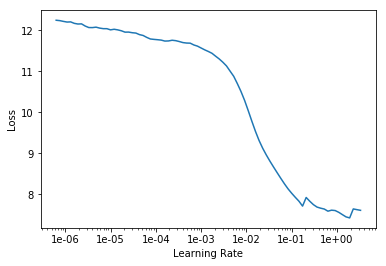

In [100]:
learn.recorder.plot()

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011669,0.007935,0.086794,01:58
1,0.009424,0.005994,0.076703,01:57
2,0.009652,0.006652,0.076023,01:59
3,0.007961,0.006945,0.083757,01:59
4,0.005702,0.005037,0.070219,01:58


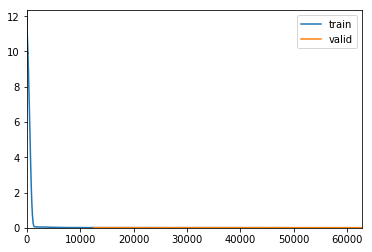

In [101]:
learn.fit_one_cycle(5, 1e-3,callbacks=[ShowGraph(learn)])

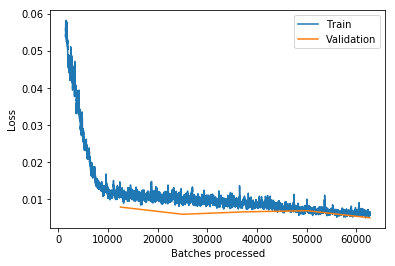

In [102]:
learn.recorder.plot_losses(skip_start=1500)

In [103]:
learn.save('Sales-1')

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.006700,0.004897,0.067780,01:58
1,0.008529,0.010599,0.096953,01:59
2,0.009826,0.005686,0.070195,01:58
3,0.011380,0.006852,0.081744,01:58
4,0.008588,0.010600,0.092923,01:58
5,0.009300,0.009168,0.089121,02:00
6,0.009032,0.006195,0.077328,01:59
7,0.007102,0.006788,0.084354,01:59
8,0.006672,0.005561,0.073640,02:00
9,0.006542,0.004583,0.065801,01:59


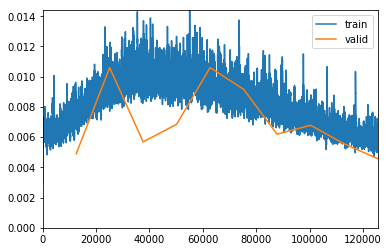

In [104]:
learn.fit_one_cycle(10, 1e-3,callbacks=[ShowGraph(learn)])

In [105]:
learn.save('Sales-2')

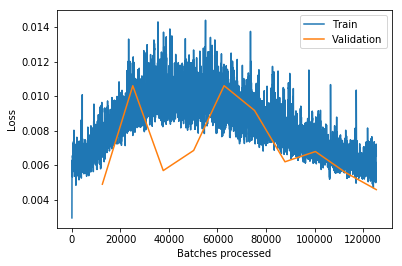

In [106]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.006165,0.005024,0.070804,02:00
1,0.006258,0.005139,0.070101,01:58


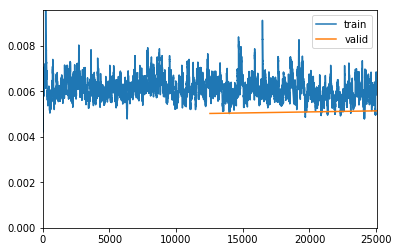

In [108]:
learn.fit_one_cycle(2, 3e-5,callbacks=[ShowGraph(learn)])

In [109]:
learn.save('Sales-3')

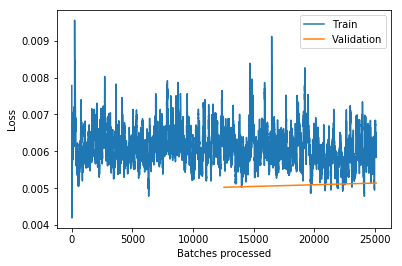

In [110]:
learn.recorder.plot_losses()

In [111]:
learn.load('Sales-3');

In [112]:
test_preds=learn.get_preds(DatasetType.Test)
test_df[dep_var]=np.exp(test_preds[0].data).numpy().T[0]
test_df[[dep_var]]=test_df[dep_var].astype("int")
test_df.head(2)

,index,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,...,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw,Customers,Sales
0,0,1,1,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0.0,0.0,4.0,0.0,0.0,1.0,503,4422
1,1,2,3,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0.0,0.0,4.0,0.0,0.0,1.0,767,7376


In [113]:
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

In class we got a score of `0.126323`, here with the pre-prediction of Customers, and more regularization, we get `0.070101`, and when submitted, we get a score of `0.10504`. the winner got `0.10021`.